# Bayesian flows

This notebook walks you through implementing and using Bayesian flows with Zuko.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

from torch import nn

import zuko
import zuko.bayesian

_ = torch.random.manual_seed(0)

## Bayesian Neural Networks (BNNs)

Bayesian neural networks (BNNs) extend standard neural networks by treating their parameters (weights and biases) as probability distributions rather than fixed values, allowing them to quantify uncertainty in their predictions. The simplest kind of Bayesian model is one where the parameters $\theta$ follow a (diagonal) Gaussian distribution $p(\theta) = \mathcal{N}(\theta \mid \mu_\theta, \sigma^2_\theta)$.

Zuko provides the [`BayesianModel`](zuko.bayesian.BayesianModel) wrapper to make any model Bayesian. The initial mean $\mu_\theta$ is set to the current value of the parameters, while the initial variance $\sigma^2_\theta$ is set by the user.

In [2]:
net = zuko.nn.MLP(5, 5, hidden_features=(64, 64), activation=nn.ELU)

bayes_net = zuko.bayesian.BayesianModel(net, init_logvar=-9.0)
bayes_net

BayesianModel(
  (base): MLP(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=5, bias=True)
  )
  (means): ParameterDict(
      (0-weight): Parameter containing: [torch.FloatTensor of size 64x5]
      (0-bias): Parameter containing: [torch.FloatTensor of size 64]
      (2-weight): Parameter containing: [torch.FloatTensor of size 64x64]
      (2-bias): Parameter containing: [torch.FloatTensor of size 64]
      (4-weight): Parameter containing: [torch.FloatTensor of size 5x64]
      (4-bias): Parameter containing: [torch.FloatTensor of size 5]
  )
  (logvars): ParameterDict(
      (0-weight): Parameter containing: [torch.FloatTensor of size 64x5]
      (0-bias): Parameter containing: [torch.FloatTensor of size 64]
      (2-weight): Parameter containing: [torch.FloatTensor of size 64x64]
      (2-bias): Parameter containing: [t

To use a Bayesian model, we have to sample parameters $\theta$ from the posterior $p(\theta)$, and then load them into the base model. Zuko's wrapper provides the [`sample_model`](zuko.bayesian.BayesianModel.sample_model) method to do so. In practice, it creates a copy of the base model and replaces its parameters with ones sampled from the posterior. This way, several models can be sampled and used at the same time.

In [3]:
x = torch.randn(5)

net_a = bayes_net.sample_model()
y_a = net_a(x)

net_b = bayes_net.sample_model()
y_b = net_b(x)

y_a, y_b

(tensor([-0.0105,  0.0765, -0.0778,  0.2437,  0.1208], grad_fn=<ViewBackward0>),
 tensor([ 0.0048,  0.0009, -0.0465,  0.2565,  0.1061], grad_fn=<ViewBackward0>))

However, this method cannot be used to train $\mu_\theta$ and $\sigma^2_\theta$ as loading sampled parameters into the base model prevents to propagate gradients. Instead, during training, it is necessary to reparametrize the base model in-place. Zuko's wrapper implements temporary in-place reparametrization as a context manager.

In [4]:
with bayes_net.reparameterize() as net_a:
    y_a = net_a(x)

with bayes_net.reparameterize() as net_b:
    y_b = net_b(x)

y_a, y_b

(tensor([-0.0676,  0.0095, -0.1110,  0.2370,  0.1980], grad_fn=<ViewBackward0>),
 tensor([-0.1230,  0.0563, -0.1155,  0.3879,  0.1370], grad_fn=<ViewBackward0>))

Training a Bayesian model consists in optimizing $\mu_\theta$ and $\sigma^2_\theta$ to minimize some objective $\mathcal{L}$, while keeping the posterior $p(\theta)$ close to a prior, typically $q(\theta) = \mathcal{N}(0, 1)$.

$$ \arg\min_{\mu_\theta, \sigma^2_\theta} \mathcal{L}(\mu_\theta, \sigma^2_\theta) + \lambda \, \text{KL}( p(\theta) || q(\theta) ) $$

Let's take an example where our model must learn to sort a list of 5 numbers.

In [5]:
optimizer = torch.optim.Adam(bayes_net.parameters(), lr=1e-3)

for epoch in range(4):
    losses = []

    for _ in range(1024):
        x = torch.randn(64, 5)
        y = torch.sort(x, dim=-1).values

        kl = bayes_net.kl_divergence()

        with bayes_net.reparameterize() as net_rep:
            loss = (net_rep(x) - y).square().mean()
            loss = loss + 1e-6 * kl
            loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f"({epoch})", losses.mean().item(), "±", losses.std().item())

(0) 0.12494310736656189 ± 0.08562330156564713
(1) 0.07492184638977051 ± 0.009858266450464725
(2) 0.06585437804460526 ± 0.006924829445779324
(3) 0.0616815909743309 ± 0.006219119764864445


After training, sampled models are (more or less) able to sort the 5 inputs. However, all sampled models have slightly different outputs.

In [6]:
x = torch.randn(5)
y = torch.sort(x).values

net_a = bayes_net.sample_model()
y_a = net_a(x)

net_b = bayes_net.sample_model()
y_b = net_b(x)

y, y_a, y_b

(tensor([-1.8011, -0.4156, -0.3794,  0.7345,  0.9244]),
 tensor([-1.7513, -0.6437, -0.0177,  0.4496,  0.8458], grad_fn=<ViewBackward0>),
 tensor([-1.5514, -0.6367, -0.2842,  0.3495,  1.0347], grad_fn=<ViewBackward0>))

## Bayesian Normalizing Flows (BNFs)

The [`BayesianModel`](zuko.bayesian.BayesianModel) wrapper works with most PyTorch modules, including normalizing flows such as neural spline flows (NSFs). In larger models, it is common to only make some layers Bayesian. The wrapper allows to include or exclude parameters based on their name. For example, the following only includes the parameters of the last layer of each hyper network, but excludes the biases.

In [7]:
flow = zuko.flows.NSF(features=3, context=5)

bayes_flow = zuko.bayesian.BayesianModel(
    flow,
    init_logvar=-9.0,
    include_params=["transform.transforms.*.hyper.4"],
    exclude_params=["**.bias"],
)
bayes_flow

BayesianModel(
  (base): NSF(
    (transform): LazyComposedTransform(
      (0): MaskedAutoregressiveTransform(
        (base): MonotonicRQSTransform(bins=8)
        (order): [0, 1, 2]
        (hyper): MaskedMLP(
          (0): MaskedLinear(in_features=8, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=69, bias=True)
        )
      )
      (1): MaskedAutoregressiveTransform(
        (base): MonotonicRQSTransform(bins=8)
        (order): [2, 1, 0]
        (hyper): MaskedMLP(
          (0): MaskedLinear(in_features=8, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=69, bias=True)
        )
      )
      (2): MaskedAutoregressiveTransform(
        (base): MonotonicRQSTransform(bins=8)
  

In [8]:
x, c = torch.randn(3), torch.randn(5)

with bayes_flow.reparameterize() as flow_a:
    log_p_a = flow_a(c).log_prob(x)

with bayes_flow.reparameterize() as flow_b:
    log_p_b = flow_b(c).log_prob(x)

log_p_a, log_p_b

(tensor(-3.0135, grad_fn=<AddBackward0>),
 tensor(-3.0946, grad_fn=<AddBackward0>))

### Two Moons example

We consider the *Two Moons* dataset for demonstrative purposes.

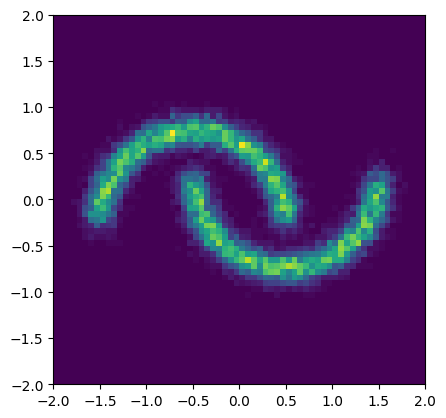

In [9]:
def two_moons(n: int, sigma: float = 1e-1):
    theta = 2 * torch.pi * torch.rand(n)
    label = (theta > torch.pi).float()

    x = torch.stack(
        (
            torch.cos(theta) + label - 1 / 2,
            torch.sin(theta) + label / 2 - 1 / 4,
        ),
        axis=-1,
    )

    return torch.normal(x, sigma), label


samples, labels = two_moons(16384)

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [10]:
trainset = data.TensorDataset(*two_moons(16384))
trainloader = data.DataLoader(trainset, batch_size=64, shuffle=True)

We train a simple Bayesian neural spline flow (NSF) to reproduce the two moons distribution.

In [11]:
flow = zuko.flows.NSF(features=2, context=1, transforms=3, hidden_features=(64, 64))
bayes_flow = zuko.bayesian.BayesianModel(
    flow,
    init_logvar=-9.0,
    include_params=["**.hyper.4"],
)

In [12]:
optimizer = torch.optim.Adam(bayes_flow.parameters(), lr=1e-3)

for epoch in range(8):
    losses = []

    for x, label in trainloader:
        c = label.unsqueeze(dim=-1)

        kl = bayes_flow.kl_divergence()

        with bayes_flow.reparameterize() as flow_rep:
            loss = -flow_rep(c).log_prob(x).mean()
            loss = loss + 1e-6 * kl
            loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f"({epoch})", losses.mean().item(), "±", losses.std().item())

(0) 0.8751118183135986 ± 0.43752822279930115
(1) 0.5845542550086975 ± 0.17458082735538483
(2) 0.5298538208007812 ± 0.14424654841423035
(3) 0.48640644550323486 ± 0.12854218482971191
(4) 0.4881558418273926 ± 0.134322851896286
(5) 0.4773902893066406 ± 0.12767525017261505
(6) 0.46446818113327026 ± 0.12396551668643951
(7) 0.46357110142707825 ± 0.1217445358633995


After training, we can sample from the Bayesian flow. Everytime we use a different set of parameters, we get a (slightly) different distribution.

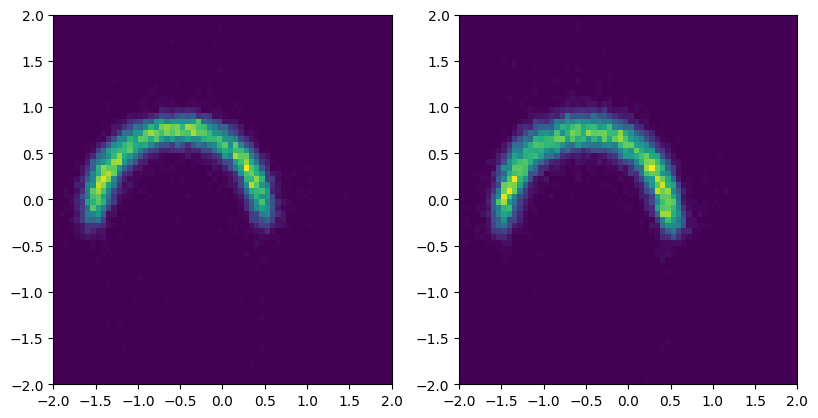

In [13]:
# sample from the Bayesian flow conditioned on the top moon label
c = torch.tensor([0.0])

flow_a = bayes_flow.sample_model()
samples_a = flow_a(c).sample((16384,))

flow_b = bayes_flow.sample_model()
samples_b = flow_b(c).sample((16384,))

fig, axs = plt.subplots(1, 2, figsize=(9.6, 4.8))
axs[0].hist2d(*samples_a.T, bins=64, range=((-2, 2), (-2, 2)))
axs[1].hist2d(*samples_b.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

It is also interesting to inspect the distribution of learned log-variances.

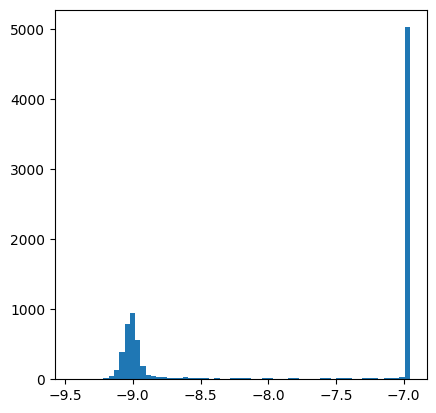

In [14]:
log_vars = []

for log_var in bayes_flow.logvars.values():
    log_vars.append(log_var.numpy(force=True).flatten())

log_vars = np.concatenate(log_vars)

plt.figure(figsize=(4.8, 4.8))
plt.hist(log_vars, bins=64)
plt.show()